In [1]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from equationmodel_ann import ann_mlp_regression, prediction_rmse_error, ann_linear_compare_graph, mlp_train_graph, errorDist
from util import ADD_data_loader, combineDF, filteringDF, getFreeSpacePathLoss, makeXforGraphWithGroupingFrequency,\
                makeXforGraph, inverseScale, samplingData, normalizeData,train_2d_graph, train_3d_graph

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

desired_width=1220
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',100)
pd.options.display.float_format = "{:.2f}".format

# Feature Engineering
datasets: iksan/nonsan/paju
1. Combine(datasets)
2. Conversion(scale)
3. Filtering 
4. Normalization(manual)

In [2]:
%autoreload

wt_fileList = {'../data/PLdata_nonsan_wt_400.csv':[('season', 0), ('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_1399.csv':[('season', 0), ('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_2249.csv':[('season', 0), ('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
sp_fileList = {'../data/PLdata_nonsan_sp_400.csv':[('season', 0.5), ('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_sp_1399.csv':[('season', 0.5), ('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_sp_2249.csv':[('season', 0.5), ('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
sm_fileList = {'../data/PLdata_nonsan_sm_400.csv':[('season', 1.0), ('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_sm_1399.csv':[('season', 1.0), ('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_sm_2249.csv':[('season', 1.0), ('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}

addWt = ADD_data_loader(wt_fileList)
print("winter data:",addWt.shape)
print("")
addSp = ADD_data_loader(sp_fileList)
print("spring data:",addSp.shape)
print("")
addSm = ADD_data_loader(sm_fileList)
print("summer data:",addSm.shape)
print("")

# print(addIksan.describe())
# print(addNonsan.describe())
# print(addPaju.describe())

addData = combineDF([addWt, addSp, addSm])
print("antenna_b height filtering-before(data count):",addData.shape)
addData = filteringDF(addData, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addData.shape)

print("freespace pathloss filtering-before(data count):",addData.shape)
addData['freePathloss'] = getFreeSpacePathLoss(addData['distance'],addData['frequency'])
addData = addData[addData['pathloss'] >= addData['freePathloss']]
print("freespace pathloss filtering-after(data count):",addData.shape)

# print("ADD data sample:\n",addData.head())

ADD data preprocessing
../data/PLdata_nonsan_wt_1399.csv: distance filtering(before):(114455, 4)
../data/PLdata_nonsan_wt_1399.csv: distance filtering(after):(10209, 4)
../data/PLdata_nonsan_wt_2249.csv: distance filtering(before):(114341, 4)
../data/PLdata_nonsan_wt_2249.csv: distance filtering(after):(10209, 4)
../data/PLdata_nonsan_wt_400.csv: distance filtering(before):(114545, 4)
../data/PLdata_nonsan_wt_400.csv: distance filtering(after):(10209, 4)
         type  distance  pathloss  heightTM  season  frequency  heightTB  heightB  heightM
type 404    m      1.01    128.20      0.02       0       1399        30       15        2
     405    m      1.01    127.43      0.02       0       1399        30       15        2
     406    m      1.01    122.07      0.02       0       1399        30       15        2
     407    m      1.02    125.59      0.02       0       1399        30       15        2
     408    m      1.03    124.88      0.02       0       1399        30       15     

In [3]:
%autoreload

targetCols = ['logDistance', 'pathloss']
xCols = ['logDistance']
yCols = 'pathloss'

samplingRatio = 0.1
addDataSampled = samplingData(addData[targetCols], samplingRatio, None)
print(addData[xCols].describe())

X = np.array(addDataSampled[xCols])
Y = np.array(addDataSampled[yCols])

data distribution(before)
       logDistance  pathloss
count     46289.00  46289.00
mean          0.24    131.75
std           0.10     14.40
min           0.00     85.72
25%           0.19    121.65
50%           0.28    132.33
75%           0.32    143.06
max           0.36    172.88
sampling shape(before):(46289, 2)
sampling shape(after):(4629, 2)
data distribution(after)
       logDistance  pathloss
count      4629.00   4629.00
mean          0.24    131.57
std           0.10     14.18
min           0.00     85.80
25%           0.19    121.66
50%           0.28    131.81
75%           0.32    142.59
max           0.36    171.24
       logDistance
count     46289.00
mean          0.24
std           0.10
min           0.00
25%           0.19
50%           0.28
75%           0.32
max           0.36


In [4]:
print("Linear Regression train/test Error")

kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)

trainErrSum, testErrSum = 0, 0
i = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    model = Ridge(alpha=0.001)
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    trainError = np.sqrt(mean_squared_error(y_train, pred_train))
    testError = np.sqrt(mean_squared_error(y_test, pred_test))
    
    trainErrSum += trainError
    testErrSum += testError

    print("#"+str(i)+" Error(RMSE)-train:{} / test:{}".format(trainError,testError))
    i+=1
i-=1
avgTrainError, avgTestError = trainErrSum/i, testErrSum/i 
print("\nAverage train error:{:.2f} | Average test error:{:.2f}".format(avgTrainError, avgTestError))

Linear Regression train/test Error
#1 Error(RMSE)-train:12.860698836812489 / test:12.723604565352089
#2 Error(RMSE)-train:12.815983655905168 / test:12.901118908991139
#3 Error(RMSE)-train:12.900068120757467 / test:12.56364983542536
#4 Error(RMSE)-train:12.781064457988819 / test:13.038990548009393
#5 Error(RMSE)-train:12.806175651034987 / test:12.940290104108088

Average train error:12.83 | Average test error:12.83


In [5]:
%autoreload
print("ANN-MLP Regression train/test Error")

kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)

modelList = []
dataSet = []
bestANNModel = None
bestIdx = 0
trainErrSum, testErrSum = 0, 0
i = 1
for train_index, test_index in kf.split(X):
#     print("TRAIN index:", train_index, "TEST index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    model = ann_mlp_regression((60,), activation='logistic', optimizer='lbfgs')
    model.fit(X_train, y_train.flatten()) 
#     trainError = prediction_rmse_error(model.predict(X_train), y_train)
#     testError = prediction_rmse_error(model.predict(X_test), y_test)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    trainError = np.sqrt(mean_squared_error(y_train, pred_train))
    testError = np.sqrt(mean_squared_error(y_test, pred_test))

    trainErrSum += trainError
    testErrSum += testError

    print("#"+str(i)+" Error(RMSE)-train:{} / test:{}".format(trainError,testError))   
    
    dataSet.append([X_train,y_train,X_test,y_test, trainError, testError])
    
    modelList.append(model)
    if i == 1:
        prevTestError = testError
        bestANNModel = model
        bestIdx = i
    if prevTestError > testError:
        bestANNModel = model
        bestIdx = i
        prevTestError = testError
    i+=1
i-=1
avgTrainError, avgTestError = trainErrSum/i, testErrSum/i 
print("\nAverage train error:{:.2f} | Average test error:{:.2f}".format(avgTrainError, avgTestError))

ANN-MLP Regression train/test Error
#1 Error(RMSE)-train:12.570528658086603 / test:12.54040547410566
#2 Error(RMSE)-train:12.667011512986713 / test:12.234958918808
#3 Error(RMSE)-train:12.475819305638074 / test:12.892183026351368
#4 Error(RMSE)-train:12.577754469840105 / test:12.212825495170833
#5 Error(RMSE)-train:12.423133172745123 / test:13.128450960046413

Average train error:12.54 | Average test error:12.60


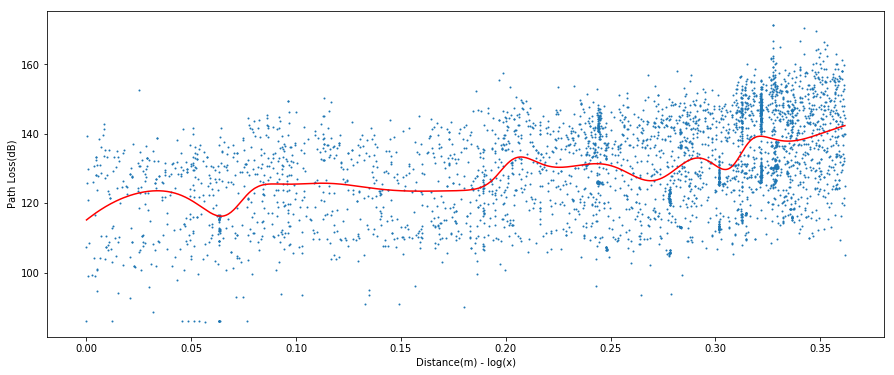

In [6]:
%autoreload
mlp_train_graph(bestANNModel, X_train, y_train, 'logistic', 'lbfgs')

Equation Derivation for trainset #1
TEST ERROR(dB)    RMSE   MAE  MAPE  RMSLE   R2
ANN Train        12.52 10.58  8.28   0.10 0.23
ANN Test         12.44 10.49  8.17   0.10 0.20
Linear Train     12.86 10.89  8.53   0.10 0.18
Linear Test      12.75 10.82  8.45   0.10 0.16
Diff(ANN,Linear)  2.91  2.45  1.89   0.02 0.80


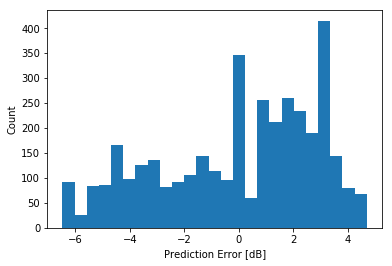

       Error(Noise) Distribution
count                    3703.00
mean                        0.00
std                         2.91
min                        -6.47
25%                        -2.26
50%                         0.70
75%                         2.39
max                         4.70

Objective Function
L_pathloss =  59.24log_d + 117.00
Equation Derivation for trainset #2
TEST ERROR(dB)    RMSE   MAE  MAPE  RMSLE   R2
ANN Train        12.61 10.66  8.32   0.10 0.22
ANN Test         12.08 10.20  8.00   0.09 0.22
Linear Train     12.93 10.96  8.57   0.10 0.18
Linear Test      12.44 10.55  8.27   0.10 0.17
Diff(ANN,Linear)  2.91  2.47  1.90   0.02 0.80


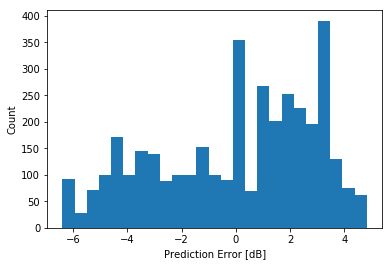

       Error(Noise) Distribution
count                    3703.00
mean                        0.00
std                         2.91
min                        -6.39
25%                        -2.46
50%                         0.48
75%                         2.41
max                         4.83

Objective Function
L_pathloss =  59.45log_d + 116.87
Equation Derivation for trainset #3
TEST ERROR(dB)    RMSE   MAE  MAPE  RMSLE   R2
ANN Train        12.44 10.51  8.19   0.10 0.22
ANN Test         12.75 10.77  8.52   0.10 0.25
Linear Train     12.77 10.81  8.43   0.10 0.17
Linear Test      13.10 11.16  8.82   0.10 0.20
Diff(ANN,Linear)  2.92  2.47  1.90   0.02 0.80


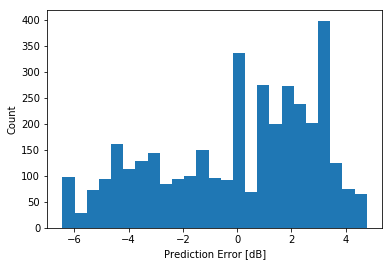

       Error(Noise) Distribution
count                    3703.00
mean                        0.00
std                         2.92
min                        -6.44
25%                        -2.39
50%                         0.69
75%                         2.39
max                         4.77

Objective Function
L_pathloss =  59.42log_d + 116.92
Equation Derivation for trainset #4
TEST ERROR(dB)    RMSE   MAE  MAPE  RMSLE   R2
ANN Train        12.58 10.63  8.33   0.10 0.22
ANN Test         12.21 10.30  7.97   0.09 0.24
Linear Train     12.92 10.95  8.59   0.10 0.17
Linear Test      12.49 10.58  8.21   0.10 0.21
Diff(ANN,Linear)  2.90  2.45  1.88   0.02 0.81


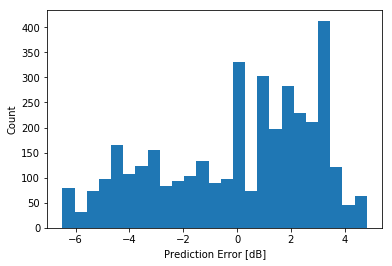

       Error(Noise) Distribution
count                    3703.00
mean                        0.00
std                         2.90
min                        -6.49
25%                        -2.35
50%                         0.81
75%                         2.38
max                         4.82

Objective Function
L_pathloss =  59.82log_d + 116.86
Equation Derivation for trainset #5
TEST ERROR(dB)    RMSE   MAE  MAPE  RMSLE    R2
ANN Train        15.56 12.59  9.85   0.12 -0.22
ANN Test         13.02 11.06  8.63   0.10  0.20
Linear Train     15.31 12.40  9.71   0.12 -0.18
Linear Test      13.36 11.28  8.80   0.10  0.16
Diff(ANN,Linear)  2.91  2.47  1.90   0.02  0.80


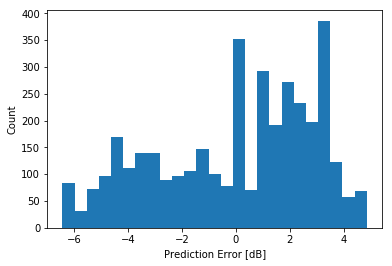

       Error(Noise) Distribution
count                    3704.00
mean                        0.00
std                         2.91
min                        -6.42
25%                        -2.45
50%                         0.58
75%                         2.38
max                         4.85

Objective Function
L_pathloss =  59.68log_d + 116.83


In [11]:
%autoreload
i = 1
bestLinearModel = None
bestIdx = 0
bestStat = None
prevTestError = 0
for X_train, y_train, X_test, y_test, trainError, testError in dataSet:

    print("Equation Derivation for trainset #{}".format(i))
    ANNPred = bestANNModel.predict(X_train)
    ANNPred_test = bestANNModel.predict(X_test)
    
    linearModel = LinearRegression().fit(X_train, ANNPred)     
    linearPredTrain = linearModel.predict(X_train)
    linearPredTest = linearModel.predict(X_test)
    
    RMSE_ANN_TRAIN = np.sqrt(mean_squared_error(y_train, ANNPred))
    RMSE_ANN_TEST = np.sqrt(mean_squared_error(y_test, ANNPred_test))
    RMSE_LIN_TRAIN = np.sqrt(mean_squared_error(y_train, linearPredTrain))
    RMSE_LIN_TEST = np.sqrt(mean_squared_error(y_test, linearPredTest))
    RMSE_LIN_ANN = np.sqrt(mean_squared_error(ANNPred, linearPredTrain))

    stat = np.array([RMSE_ANN_TRAIN, mean_absolute_error(y_train, ANNPred),mean_absolute_percentage_error(y_train, ANNPred),np.sqrt(mean_squared_log_error(y_train, ANNPred)),r2_score(y_train, ANNPred),\
                    RMSE_ANN_TEST, mean_absolute_error(y_test, ANNPred_test),mean_absolute_percentage_error(y_test, ANNPred_test),np.sqrt(mean_squared_log_error(y_test, ANNPred_test)),r2_score(y_test, ANNPred_test),\
                    RMSE_LIN_TRAIN, mean_absolute_error(y_train, linearPredTrain),mean_absolute_percentage_error(y_train, linearPredTrain),np.sqrt(mean_squared_log_error(y_train, linearPredTrain)),r2_score(y_train, linearPredTrain),\
                    RMSE_LIN_TEST, mean_absolute_error(y_test, linearPredTest),mean_absolute_percentage_error(y_test, linearPredTest), np.sqrt(mean_squared_log_error(y_test, linearPredTest)),r2_score(y_test, linearPredTest),\
                    RMSE_LIN_ANN, mean_absolute_error(ANNPred, linearPredTrain),mean_absolute_percentage_error(ANNPred, linearPredTrain), np.sqrt(mean_squared_log_error(ANNPred, linearPredTrain)),r2_score(ANNPred, linearPredTrain)])

    print(pd.DataFrame(stat.reshape((5,5)),index=pd.Index(['ANN Train','ANN Test','Linear Train','Linear Test','Diff(ANN,Linear)']), columns=pd.Index(['RMSE','MAE','MAPE','RMSLE','R2'],name='TEST ERROR(dB)')))
    errorDist(ANNPred, linearPredTrain)

    print("\nObjective Function")
    print("L_pathloss = {:6.2f}log_d + {:6.2f}".format(linearModel.coef_[0],linearModel.intercept_))
    if i == 1:
        prevTestError = RMSE_LIN_TEST
        bestLinearModel = linearModel
        bestIdx = i
        bestStat = stat
    if prevTestError > RMSE_LIN_TEST:
        bestLinearModel = linearModel
        bestIdx = i
        bestStat = stat
        prevTestError = RMSE_LIN_TEST
    i+=1

In [12]:
%autoreload
print("best model:")
print("L_pathloss = {:6.2f}log_d + {:6.2f}".format(bestLinearModel.coef_[0],bestLinearModel.intercept_))
print(pd.DataFrame(bestStat.reshape((5,5)),index=pd.Index(['ANN Train','ANN Test','Linear Train','Linear Test','Diff(ANN,Linear)']), columns=pd.Index(['RMSE','MAE','MAPE','RMSLE','R2'],name='TEST ERROR(dB)')))

best model:
L_pathloss =  59.45log_d + 116.87
TEST ERROR(dB)    RMSE   MAE  MAPE  RMSLE   R2
ANN Train        12.61 10.66  8.32   0.10 0.22
ANN Test         12.08 10.20  8.00   0.09 0.22
Linear Train     12.93 10.96  8.57   0.10 0.18
Linear Test      12.44 10.55  8.27   0.10 0.17
Diff(ANN,Linear)  2.91  2.47  1.90   0.02 0.80
